# Check GPU status

Make surre to use : GPU runtime mode (Runtime->Change Runtime type -> python3 + GPU
)



##Mount Goolge Drive

In [1]:
# link to google drive

from google.colab import drive
#drive.mount('/content/gdrive/')
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


### Ejecutar Codigo en Google Drive

In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/Deep_Prior_Low_Rank-master"

/content/gdrive/My Drive/Colab Notebooks/Deep_Prior_Low_Rank-master


In [ ]:
%ls
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt

BGU_9.mat           end4_Materials.fig  MAIN.py         RunColab_unmixing.ipynb
end4_Abundance.fig  H1Shot.mat          __pycache__/    Script.ipynb
end4.mat            LegoCars.mat        RunColab.ipynb


In [3]:
def psnr(img, res):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    img = np.squeeze(img)
    res = np.squeeze(res)
    [M, N, L] = img.shape
    temp = 1. / (M * N * L) * np.sum(np.power(img - res, 2))
    psnr = 10 * np.log10(np.max(np.power(img, 2) / temp))
    return psnr

(1, 100, 100, 1, 4)


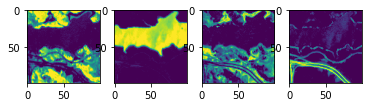

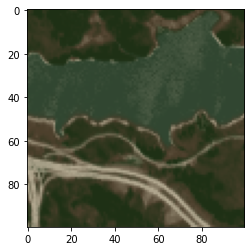

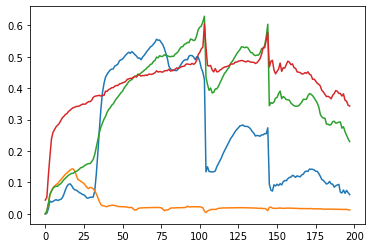

In [ ]:
M = scipy.io.loadmat('end4.mat')['M']
A = scipy.io.loadmat('end4.mat')['A']
A = tf.expand_dims(tf.expand_dims(tf.reshape(tf.transpose(A,[1,0]),[100,100,4]),0),3)
M = tf.expand_dims(tf.expand_dims(tf.expand_dims(M,0),0),0)

print(A.shape)

Hy = tf.reduce_sum(tf.multiply(M,A),axis=4)



plt.subplot(1,4,1),plt.imshow(A[0,:,:,0,0].numpy())
plt.subplot(1,4,2),plt.imshow(A[0,:,:,0,1].numpy())
plt.subplot(1,4,3),plt.imshow(A[0,:,:,0,2].numpy())
plt.subplot(1,4,4),plt.imshow(A[0,:,:,0,3].numpy())
plt.show()
bad = [int(180),int(100),int(30)]


Hy = Hy.numpy()
most = np.squeeze(Hy)[:,:,[25,16,8]]*2
plt.imshow(most),plt.show()

Ab = np.squeeze(A.numpy(),axis=3)


Mb = tf.reshape(tf.transpose(M,[0,4,3,2,1]),[1,2,2,198]).numpy()
Mb = Mb

plt.plot(Mb[0,0,0,:])
plt.plot(Mb[0,0,1,:])
plt.plot(Mb[0,1,0,:])
plt.plot(Mb[0,1,1,:])
plt.show()

def LMM(x):
  Ab = x[0]
  Mb = x[1]

  Mb = tf.reshape(Mb,[1,1,1,4,198])
  Ab = tf.expand_dims(Ab,-1)
  Hy = tf.reduce_sum(tf.multiply(Mb,Ab),axis=3)

  return Hy



In [ ]:
!ls

BGU_9.mat	    end4_Materials.fig	MAIN.py		RunColab_unmixing.ipynb
end4_Abundance.fig  H1Shot.mat		__pycache__	Script.ipynb
end4.mat	    LegoCars.mat	RunColab.ipynb


In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.constraints import MinMaxNorm,NonNeg
import tensorflow as tf

#-------------------------------------------- CASSI LAYER-----------------------------------------
class Endmemebers_Layer(Layer):
    def __init__(self, L=16, rank=1, **kwargs):
        self.L = L
        self.rank = rank
        super(Endmemebers_Layer, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'L': self.L,
            'rank': self.rank})
        return config

    def build(self, input_shape):

            Endmemb = np.random.uniform(0, 1, (1, 1, 1, self.rank, self.L))
            Endmemb = tf.constant_initializer(Endmemb)
            self.Endmemb = self.add_weight(name='Endmemb', shape=(1, 1, 1, self.rank, self.L), initializer=Endmemb,
                                           constraint=NonNeg(), trainable=True)

    def call(self, inputs, **kwargs):

        Ab = tf.expand_dims(inputs,-1)
        Hy = tf.reduce_sum(tf.multiply(self.Endmemb,Ab),axis=3)
        return Hy


# Network part for Abundance Map



In [ ]:
from keras import backend as K
from IPython.display import clear_output
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

def Abund_net(inputs,rank):
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    conv4 = Conv2D(16, 3, activation='relu', padding='same')(conv3)
    final = Conv2D(rank, 1, activation='softmax', padding='same', name='Abund_final')(conv4)

    return final

def Abundance_network(pretrained_weights=None, input_size=(512,512, 31),batch_size = 1, rank = 1):
    inputs = Input(input_size)
    final = Abund_net(inputs,rank)
    hy = Endmemebers_Layer(L=input_size[2], rank=rank)(final)

    model = Model(inputs, [hy,final])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model




In [ ]:
def Abundance_loss():
  def lossimage(y_true, y_pred):
      # batch x W x H X r
    val = tf.reduce_sum(tf.square(y_true - tf.reduce_sum(y_pred,axis=3)))
    return val
  return lossimage

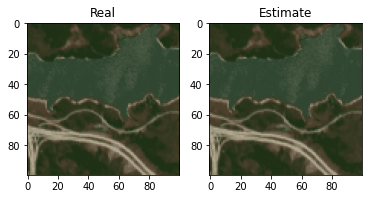

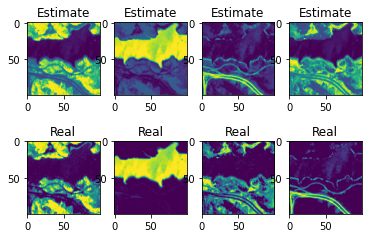

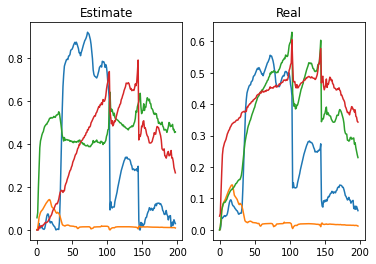

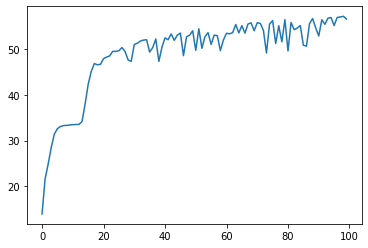

([<matplotlib.lines.Line2D at 0x7fda4bbb9400>], None)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-3,
  decay_steps=10000,
  decay_rate=0.95)
optimizad = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Abun = Abundance_network(input_size=(100, 100, 198), batch_size=1, rank=4)
Abun.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()])
Internal_iter = 500
psnr_deep = []
for i in range(100):
    print('Iteration = ' + str(i))
    clear_output(wait=True)

    Abun.fit(Hy, [Hy, np.ones((1,100,100))], epochs=Internal_iter, batch_size=1, verbose=0)
    temporal = Abun.get_weights()
    # obtain the CA
    Endm = np.squeeze(temporal[-1])
    H_high = K.function([Abun.layers[0].input], [Abun.get_layer('Abund_final').output])
    Image_recon = K.function([Abun.layers[0].input], [Abun.layers[-1].output])
    Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
    rest_h = np.squeeze(np.asarray(H_high(Hy)))
    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

    pp = Img_recon[:,:,[25,16,8]]*2

    plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
    plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate'), plt.show()


    plt.subplot(2, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
    plt.subplot(2, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
    plt.subplot(2, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
    plt.subplot(2, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')

    plt.subplot(2, 4, 5), plt.imshow(Ab[0, :, :, 0]), plt.title('Real')
    plt.subplot(2, 4, 6), plt.imshow(Ab[0, :, :, 1]), plt.title('Real')
    plt.subplot(2, 4, 7), plt.imshow(Ab[0, :, :, 2]), plt.title('Real')
    plt.subplot(2, 4, 8), plt.imshow(Ab[0, :, :, 3]), plt.title('Real')
    plt.show()

    plt.subplot(1,2,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
    plt.subplot(1, 2, 2), plt.plot(Mb[0,0,0,:])
    plt.plot(Mb[0,0,1,:])
    plt.plot(Mb[0,1,0,:])
    plt.plot(Mb[0,1,1,:]), plt.title('Real')
    plt.show()

    plt.subplot()

plt.plot(psnr_deep), plt.show()



(<matplotlib.axes._subplots.AxesSubplot at 0x7f1db96790b8>,
 Text(0.5, 1.0, 'Estimate'))

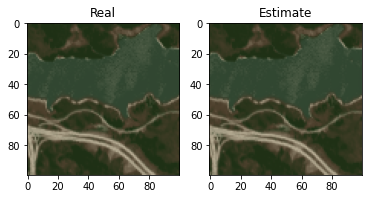

In [ ]:
Image_recon = K.function([Abun.layers[0].input], [Abun.layers[-1].output])
Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
pp = Img_recon[:,:,[25,16,8]]*2


plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate')

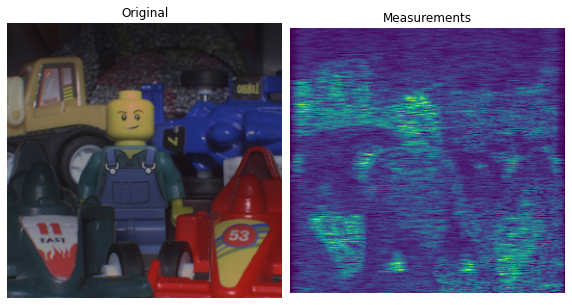

In [ ]:
from scipy.sparse import csr_matrix, find
from MAIN import *
# load H
Mat= scipy.io.loadmat('H1Shot.mat')
H = Mat['H']
[row,col,val] = find(H)
ind = np.asarray([row,col])
ind = np.transpose(ind,(1,0))

H_s = tf.SparseTensor(indices = ind, values = val, dense_shape=[H.shape[0], H.shape[1]])

# Load Data
Mat= scipy.io.loadmat('LegoCars.mat')
testSI=np.double(Mat['hyperimg'])
testSI=testSI/np.max(testSI)
RGB = testSI[:,:,(8, 4, 1)]
[m,n,l]=testSI.shape

# Measurements
y = Hxfunction(tf.constant(testSI),largo=m,ancho=n,profun=l,H=H_s)
y = np.double(y.numpy())

fig, axs = plt.subplots(1,2,figsize=(10,10))
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.03)


axs[0].imshow(RGB)
axs[0].axis('off')
axs[0].set_title('Original')


axs[1].imshow(y.reshape((m,n+l-1),order="F")/np.max(y))
axs[1].axis('off')
axs[1].set_title('Measurements')

del H

In [ ]:
def LMM_Net_reconstruction(pretrained_weights=None, input_size = (256,256,1), L=10, H=0, fact = 0.5, rank = 20):
    inputs = Input(input_size)
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(inputs)
    drop1 = Dropout(0.2)(inicial)

    Ab = Abund_net(drop1,rank)
    hy = Endmemebers_Layer(L=L, rank=rank)(Ab)

    final =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun=L,H=H)) (hy)

    model = Model(inputs, [final,Ab])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

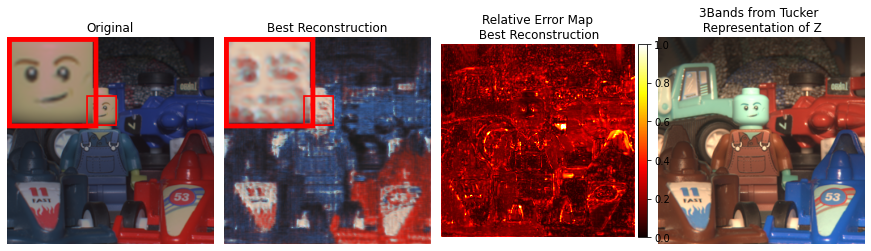

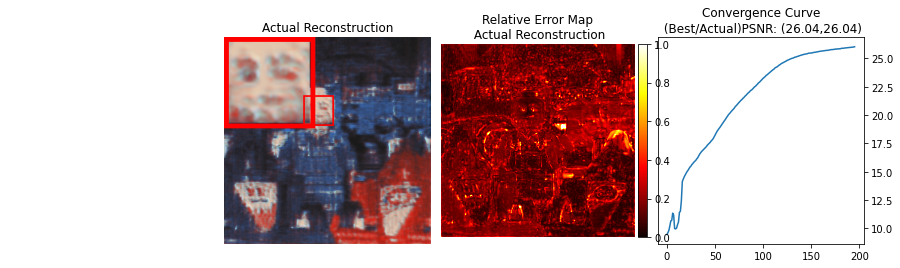

Epoch 09800: PSNR 26.041 : Max PSNR 26.041
Epoch 09850: PSNR 26.036 : Max PSNR 26.041
Epoch 09900: PSNR 26.060 : Max PSNR 26.060
Epoch 09950: PSNR 26.074 : Max PSNR 26.074


In [ ]:
#Reconstruction Parameters setup
rho = .2
learning_rate = 1e-4
iters = 20000

#Visualization Parameters setup
Freq = 50

#Optimization
model = LMM_Net_reconstruction(input_size = (m,n,l), L=l,H=H_s, fact= rho)
optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9, amsgrad=False);

model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()])

model.fit(np.zeros(shape=(1,m,n,l)), [y, np.ones((1,m,n))], epochs = iters,batch_size=1,callbacks=[myCallback(testSI,Freq)],verbose=0)
